<a href="https://colab.research.google.com/github/fabianfallasmoya/agro/blob/master/MatrixVisualizeEfficientDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Mount drive, download torch, and import the required modules

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install pycocotools numpy==1.16.0 opencv-python tqdm tensorboard tensorboardX pyyaml webcolors matplotlib
!pip install torch==1.4.0
!pip install torchvision==0.5.0

In [35]:
import os
import sys
if "Yet-Another-EfficientDet-Pytorch" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
  os.chdir('Yet-Another-EfficientDet-Pytorch')
  sys.path.append('.')
else:
  !git pull

Already up to date.


In [4]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

### 1. Address the weights, the original image, and the slices of that original image

In [5]:
pathOfWeights = '/content/drive/My Drive/pineapple_research/Pineapple_Datasets/EfficientDet/efficientdet-d0_7147_85770.pth'
##'pathOfWeights' variable is the current location for the EfficientDet 
completeImage = '/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007.JPG'
directoryOfImages = '/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/'


### 2. Processing, concatenating, and showing the image results 

In [6]:
imageRootName = completeImage[len(completeImage)-12:len(completeImage)-4]
### Important data from the original Image
originalImage = cv2.imread(completeImage)
heightOriginalImage = originalImage.shape[0]
widthOriginalImage = originalImage.shape[1]
### Important data from the pieces of images
pieceImageSample = cv2.imread(directoryOfImages +imageRootName+ '_01_01.jpg')
heightPieces = pieceImageSample.shape[0]
widthPieces = pieceImageSample.shape[1]
##Getting the dimensions of the detection matrix
columnsGrid = widthOriginalImage/widthPieces
rowsGrid = heightOriginalImage/heightPieces
##Showing some important data before the counting process
print('--------------------------------------------')
print('Important data of the test:')
print('--------------------------------------------')
print('Original image important data:')
print('Name:')
print(imageRootName)
print('Width:')
print(widthOriginalImage)
print('Height:')
print(heightOriginalImage)
print('---------------------')
print('Pieces images important data:')
print('Width:')
print(widthPieces)
print('Height:')
print(heightPieces)
print('---------------------')
print('Total of pieces:')
print((widthOriginalImage*heightOriginalImage)/(widthPieces*heightPieces))
print('Columns grid:')
print(columnsGrid)
print('Rows grid:')
print(rowsGrid)
print('--------------------------------------------')

--------------------------------------------
Important data of the test:
--------------------------------------------
Original image important data:
Name:
00000007
Width:
4056
Height:
2280
---------------------
Pieces images important data:
Width:
1014
Height:
1140
---------------------
Total of pieces:
8.0
Columns grid:
4.0
Rows grid:
2.0
--------------------------------------------


In [51]:
## This method returns the bounding boxes and its metadate from a single image
def visualizeBBox(directoryOfImages,pathOfWeights,imageName):
  compound_coef = 0
  force_input_size = None  # set None to use default size
  img_path  = directoryOfImages + imageName
  print(img_path)
  threshold = 0.5
  iou_threshold = 0.4

  use_cuda = True
  use_float16 = False
  cudnn.fastest = True
  cudnn.benchmark = True

  obj_list = ['pineapple']

  # tf bilinear interpolation is different from any other's, just make do
  input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
  input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
  ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

  if use_cuda:
      x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
  else:
      x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

  x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

  model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                              # replace this part with your project's anchor config
                              ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                              scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

  model.load_state_dict(torch.load(pathOfWeights))
  model.requires_grad_(False)
  model.eval()

  if use_cuda:
      model = model.cuda()
  if use_float16:
      model = model.half()

  with torch.no_grad():
      features, regression, classification, anchors = model(x)

      regressBoxes = BBoxTransform()
      clipBoxes = ClipBoxes()

      out = postprocess(x,
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

  out = invert_affine(framed_metas, out)
  return out

/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_01_01.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_01_02.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_01_03.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_01_04.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_02_01.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_02_02.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_02_03.jpg
/content/drive/My Drive/pineapple_research/Pineapple_Datasets/ConcatenateImages/00000007/00000007_02_04.jpg


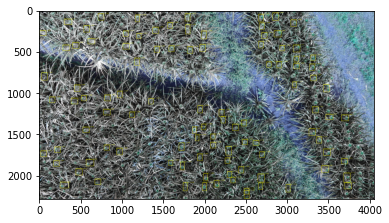

,Image,Detections
0,00000007_01_01,14
1,00000007_01_02,15
2,00000007_01_03,9
3,00000007_01_04,9
4,00000007_02_01,11
5,00000007_02_02,12
6,00000007_02_03,20
7,00000007_02_04,10
8,Total:,100


In [65]:
matrix = [] ##This matrix will contain the bunch of 
#bbox coordinates(from slices images) traduced them to the original image (drone image)

##These coming 3 variables are made to build a summary data frame
names = []
quantityDetected = []
counter = 0;
####
ori_img = cv2.imread(completeImage)##Getting the original image
obj_list = ['pineapple'] ## The classes name list for the detected objects
### This coming while loop will build the matrix containing the bbox coordinates
## Also, it will draw the bboxes detections in the image and will make a brief summary of the counting process
i = 1
j = 1
while i<=rowsGrid:
  matrix.append([])
  while j<=columnsGrid:
    ## Obtaining the detection info from a single slice image
    out = visualizeBBox(directoryOfImages,pathOfWeights,imageRootName+'_0'+str(i)+'_0'+str(j)+'.jpg') 
    ## Analizing the bunch of detections from the slice image
    for bboxCount in range(len(out[0]['rois'])):
      ## Translating the slice coordinates to the original image
      (x1, y1, x2, y2) = out[0]['rois'][bboxCount].astype(np.int)
      (nx1,ny1,nx2,ny2) = (x1+((j-1)*int(widthPieces)), y1+((i-1)*int(heightPieces)) , x2+((j-1)*int(widthPieces)), y2+((i-1)*int(heightPieces)))
      out[0]['rois'][bboxCount] = (nx1,ny1,nx2,ny2)
      ## Drawing the bounding boxes and its scores in the original image
      cv2.rectangle(ori_img, (nx1, ny1), (nx2, ny2), (255, 255, 0), 2)
      obj = obj_list[out[0]['class_ids'][bboxCount]]
      score = float(out[0]['scores'][bboxCount])
      cv2.putText(ori_img, '{}, {:.3f}'.format(obj, score),
                          (nx1,ny1), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          (255, 255, 0), 1)
      
    ## Appending the slice image coordinates translated to the original image into the matrix
    matrix[i-1].append(out[0]['rois'])
    ## Appending important info into lists to build the summary of the counting process
    names.append(imageRootName + '_0'+str(i)+'_0'+str(j)) ##Appending the name of the slice image
    quantityDetected.append(len(matrix[i-1][j-1])) ##Appending the detections quantity of the slice image
    counter = counter + len(matrix[i-1][j-1]) ##Increasing the counter of the total detection counting in the original image
    j = j+1
  j=1
  i = i+1

# Saving the original image in the environment (see the Files section)
cv2.imwrite('/content/'+"CompleteImgVisualized.jpg", ori_img)
## Showing the original image (it will be not well visualized because the image is too big it is better to download it)
plt.imshow(ori_img)
plt.show()

##Adding the total detections counted into the lists to be shown in the summary
names.append('Total:')
quantityDetected.append(counter)
##Showing the summary of the counting process
df = pd.DataFrame(list(zip(names, quantityDetected)), 
               columns =['Image', 'Detections']) 
df